In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [4]:
import sys 
sys.path.append("../../")

In [5]:
from proj_mod import drop_extreme

In [ ]:
# from proj_mod import data_shifting

In [7]:
all_data=pd.read_csv("../../data/processed/all_data_collection.csv")

In [8]:
all_data.columns

Index(['Date', 'tech_index_daily_pro_change', 'cop_daily_pro_change',
       'gold_daily_pro_change', 'silv_daily_pro_change',
       'pal_daily_pro_change', 'plat_daily_pro_change',
       'crude_oil_daily_pro_change', 'fed_dff_daily',
       'ppi314_monthly_pro_change', 'ppi332_monthly_pro_change',
       'ppi333_monthly_pro_change', 'ppi334_monthly_pro_change',
       'ppi335_monthly_pro_change', 'ppi336_monthly_pro_change',
       'ppi339_monthly_pro_change', 'ppi516_monthly_pro_change',
       'ppi517_monthly_pro_change', 'ppi5132_monthly_pro_change',
       'ppi5182_monthly_pro_change'],
      dtype='object')

In [9]:
all_data_extended = all_data.copy(deep=True)

In [10]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression

In [11]:
arr_mse_kfold_collection=[] #Each row is for one int_extend. Then for each row index zero is for the training with extreme values, and index one is for the training without extreme values. 
arr_mse_kfold_de_collection=[] #Each row is for one int_extend. Then for each row index zero is for the training with extreme values, and index one is for the training without extreme values. 
all_data_extended_train=all_data_extended[all_data_extended["Date"]<"2024-01-01"].dropna()
    
X_train=all_data_extended_train.iloc[:,2:]
y_train=all_data_extended_train.iloc[:,1]
spineline_pipe = Pipeline([
("std", StandardScaler()),               # 1) Standardize features
("spline", SplineTransformer(n_knots=2, degree=1)),
("regressor", LinearRegression())        # 2) Fit a regression model
])
time_kfold=TimeSeriesSplit(n_splits=5)
fold_mse=[]
fold_mse_de=[]
#First for without deleting extreme values. 
for index_train, index_test in time_kfold.split(X_train): 
    X_tt=X_train.iloc[index_train]
    y_tt=y_train.iloc[index_train]
    X_ho=X_train.iloc[index_test]
    y_ho=y_train.iloc[index_test]
    all_data_ho_de=drop_extreme.drop_by_sort(df_in=all_data_extended_train.iloc[index_test], fl_low=0.01, fl_high=0.99)
    X_ho_de=all_data_ho_de.iloc[:,2:]
    y_ho_de=all_data_ho_de.iloc[:,1]
    spineline_pipe.fit(X=X_tt,y=y_tt)
    pred=spineline_pipe.predict(X=X_ho)
    error=mean_squared_error(y_pred=pred,y_true=y_ho)
    fold_mse.append(error)
    pred_de=spineline_pipe.predict(X=X_ho_de)
    error_de=mean_squared_error(y_pred=pred_de,y_true=y_ho_de)
    fold_mse_de.append(error_de)
mean_error=np.mean(fold_mse)
arr_mse_kfold_collection.append([])
arr_mse_kfold_collection[-1].append(mean_error)
mean_error_de=np.mean(fold_mse_de)
arr_mse_kfold_de_collection.append([])
arr_mse_kfold_de_collection[-1].append(mean_error_de)
print("mse trained WITHOUT deleting extreme values is "+str(mean_error)+" with k fold.")
fold_mse=[]
fold_mse_de=[]
#Then the one with deleting extreme values. 
for index_train, index_test in time_kfold.split(X_train): 
    all_data_tt=drop_extreme.drop_by_sort(df_in=all_data_extended_train.iloc[index_train], fl_low=0.001, fl_high=0.999)  #all_data_extended_train.iloc[index_train]
    all_data_ho=drop_extreme.drop_by_sort(df_in=all_data_extended_train.iloc[index_test], fl_low=0.01, fl_high=0.99) #all_data_extended_train.iloc[index_test]
    X_tt=all_data_tt.iloc[:,2:] #drop_extreme.drop_by_sort(df_in=X_train.iloc[index_train], fl_low=0.01, fl_high=0.99)     #X_de_train.iloc[index_train]
    y_tt=all_data_tt.iloc[:,1] #drop_extreme.drop_by_sort(df_in=y_train.iloc[index_train], fl_low=0.01, fl_high=0.99) 
    X_ho_de=all_data_ho.iloc[:,2:] #drop_extreme.drop_by_sort(df_in=X_train.iloc[index_test], fl_low=0.01, fl_high=0.99) #X_train.iloc[index_test]
    y_ho_de=all_data_ho.iloc[:,1] #drop_extreme.drop_by_sort(df_in=y_train.iloc[index_test], fl_low=0.01, fl_high=0.99) #y_train.iloc[index_test]
    X_ho=X_train.iloc[index_test]
    y_ho=y_train.iloc[index_test]
    spineline_pipe.fit(X=X_tt,y=y_tt)
    pred=spineline_pipe.predict(X=X_ho)
    error=mean_squared_error(y_pred=pred,y_true=y_ho)
    fold_mse.append(error)
    pred_de=spineline_pipe.predict(X=X_ho_de)
    error_de=mean_squared_error(y_pred=pred_de,y_true=y_ho_de)
    fold_mse_de.append(error_de)
mean_error=np.mean(fold_mse)
arr_mse_kfold_collection[-1].append(mean_error)
mean_error_de=np.mean(fold_mse_de)
arr_mse_kfold_de_collection[-1].append(mean_error_de)
print("mse trained WITH deleting extreme values is "+str(mean_error)+" with k fold.")
    

        

mse trained WITHOUT deleting extreme values is 2.0320833473198574 with k fold.
mse trained WITH deleting extreme values is 2.0413974367219887 with k fold.


In [12]:
arr_mse_kfold_collection

[[np.float64(2.0320833473198574), np.float64(2.0413974367219887)]]

In [13]:
arr_mse_kfold_de_collection

[[np.float64(1.5218322206045258), np.float64(1.5216090898845747)]]

In [14]:
arr_in=np.array(arr_mse_kfold_de_collection).transpose()

In [15]:
np.array(arr_mse_kfold_collection).transpose()

array([[2.03208335],
       [2.04139744]])

In [16]:
df_error=pd.DataFrame({"WITH extreme":np.array(arr_mse_kfold_collection).transpose()[0], "WITHOUT extreme":np.array(arr_mse_kfold_collection).transpose()[1]})

We first train the one without extreme values, tested on both test data with and without extremes. 

In [18]:
all_data_extended = all_data.copy(deep=True)

In [19]:
# all_data_extended_de=drop_extreme.drop_by_sort(df_in=all_data_extended.dropna(),fl_low=0.001,fl_high=0.999)
all_data_extended_train_de=drop_extreme.drop_by_sort(df_in=all_data_extended_train,fl_low=0.001,fl_high=0.999)
all_data_extended_test=all_data_extended[all_data_extended["Date"]>="2024-01-01"].dropna()

In [20]:
all_data_extended_test_de=drop_extreme.drop_by_sort(df_in=all_data_extended_test,fl_low=0.01,fl_high=0.99)

In [21]:
X_train=all_data_extended_train.iloc[:,2:]
y_train=all_data_extended_train.iloc[:,1]
X_de_train=all_data_extended_train_de.iloc[:,2:]
y_de_train=all_data_extended_train_de.iloc[:,1]
X_test=all_data_extended_test.iloc[:,2:]
y_test=all_data_extended_test.iloc[:,1]

In [22]:
X_de_test=all_data_extended_test_de.iloc[:,2:]
y_de_test=all_data_extended_test_de.iloc[:,1]

In [23]:
spineline_pipe = Pipeline([
    ("std", StandardScaler()),               # 1) Standardize features
    ("spline", SplineTransformer(n_knots=2, degree=1)),
    ("regressor", LinearRegression())        # 2) Fit a regression model
])

In [24]:
spineline_pipe.fit(X=X_de_train,y=y_de_train)

Pipeline(steps=[('std', StandardScaler()),
                ('spline', SplineTransformer(degree=1, n_knots=2)),
                ('regressor', LinearRegression())])

First, test on the test set with extreme values. 

In [25]:
pred_extreme=spineline_pipe.predict(X=X_test)

In [26]:
mse_extreme=mean_squared_error(y_pred=pred_extreme,y_true=y_test)

Graph for trained without extreme, tested with extreme. 

In [27]:
mse_extreme

1.4930118250264264

<function matplotlib.pyplot.show(close=None, block=None)>

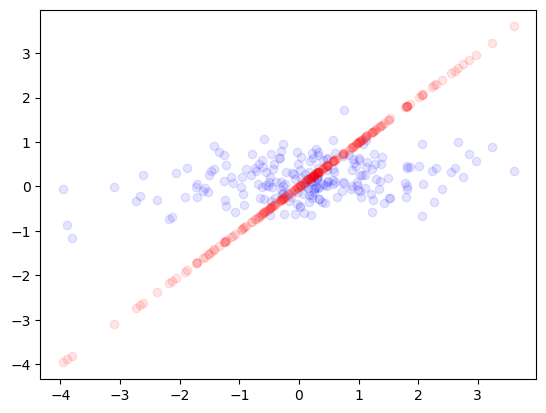

In [28]:
plt.scatter(x=y_test,y=pred_extreme,c="b",alpha=0.1,label="pred")
plt.scatter(x=y_test,y=y_test,c="r",alpha=0.1,label="true")
plt.show

Then, test on the test set without extreme values. 

In [29]:
pred_noextreme=spineline_pipe.predict(X=X_de_test)

In [30]:
mse_noextreme=mean_squared_error(y_pred=pred_noextreme,y_true=y_de_test)

Graph for trained without extreme, tested without extreme. 

In [31]:
mse_noextreme

1.3473170335866287

<function matplotlib.pyplot.show(close=None, block=None)>

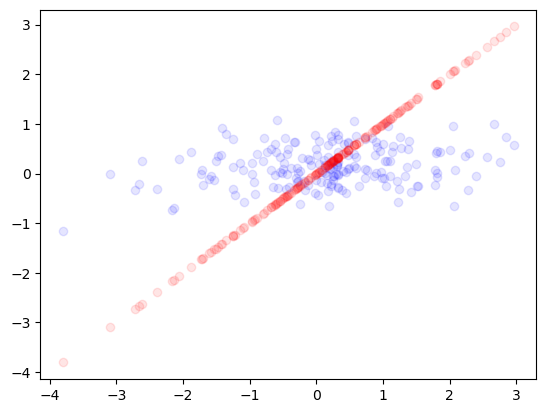

In [32]:
plt.scatter(x=y_de_test,y=pred_noextreme,c="b",alpha=0.1,label="pred")
plt.scatter(x=y_de_test,y=y_de_test,c="r",alpha=0.1,label="true")
plt.show

Features focused, in order of importance, are 'cop_daily_pro_change', 'gold_daily_pro_change', 'crude_oil_daily_pro_change', 'pal_daily_pro_change', 'plat_daily_pro_change', 

In [33]:
all_data_train=all_data[all_data_extended["Date"]<"2024-01-01"]

In [34]:
all_data_test=all_data[all_data_extended["Date"]>="2024-01-01"]

In [35]:
all_data_test_de=drop_extreme.drop_by_sort(df_in=all_data_test,fl_low=0.01,fl_high=0.99)

In [36]:
X_train=all_data_train.iloc[:,2:]
y_train=all_data_train.iloc[:,1]
X_test=all_data_test.iloc[:,2:]
y_test=all_data_test.iloc[:,1]
X_de_test=all_data_test_de.iloc[:,2:]
y_de_test=all_data_test_de.iloc[:,1]

In [37]:
spineline_pipe = Pipeline([
    ("std", StandardScaler()),                  # standardize features
    ("spline", SplineTransformer(n_knots=2, degree=1)),
    ("regressor", LinearRegression())           # final estimator
])

In [38]:
spineline_pipe.fit(X=X_train,y=y_train)

Pipeline(steps=[('std', StandardScaler()),
                ('spline', SplineTransformer(degree=1, n_knots=2)),
                ('regressor', LinearRegression())])

In [39]:
pred_extreme=spineline_pipe.predict(X=X_test)

In [40]:
pred_noextreme=spineline_pipe.predict(X_de_test)

In [41]:
mse_extreme=mean_squared_error(y_pred=pred_extreme,y_true=y_test)

In [42]:
mse_noextreme=mean_squared_error(y_pred=pred_noextreme,y_true=y_de_test)

Graph for trained with extreme and tested with extreme. 

In [43]:
mse_extreme

1.5124739248435195

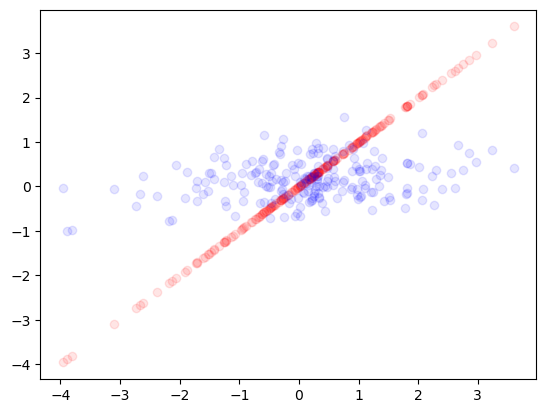

In [44]:
plt.scatter(x=y_test,y=y_test,c="r",alpha=0.1,label="true")
plt.scatter(x=y_test,y=pred_extreme,c="b",alpha=0.1,label="pred")
plt.show()

Graph for trained with extreme and tested with no extreme. 

In [45]:
mse_noextreme

1.3591363272625205

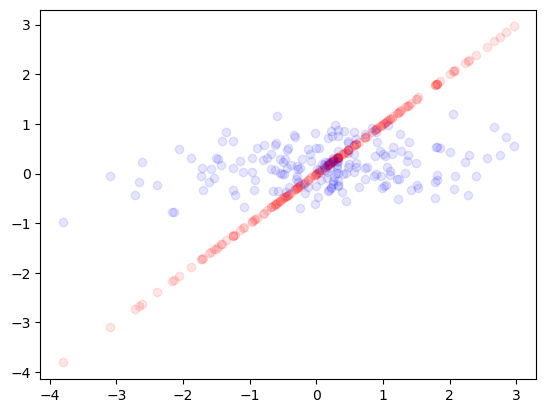

In [46]:
plt.scatter(x=y_de_test,y=y_de_test,c="r",alpha=0.1,label="true")
plt.scatter(x=y_de_test,y=pred_noextreme,c="b",alpha=0.1,label="pred")
plt.show()

It seems more sifting does cause worse effect on whole test set, but it also seems to reduce error in the test set with no extreme values, let's try that out as well. 

In [47]:
all_data_extended = all_data.copy(deep=True)
for int_extend in range(11): 
    
    all_data_extended_train=all_data_extended[all_data_extended["Date"]<"2024-01-01"].dropna()
    all_data_extended_train_de=drop_extreme.drop_by_sort(df_in=all_data_extended_train,fl_low=0.001,fl_high=0.999)
    all_data_extended_test=all_data_extended[all_data_extended["Date"]>="2024-01-01"].dropna()
    all_data_extended_test_de=drop_extreme.drop_by_sort(df_in=all_data_extended_test,fl_low=0.01,fl_high=0.99)
    X_train=all_data_extended_train.iloc[:,2:]
    y_train=all_data_extended_train.iloc[:,1]
    X_de_train=all_data_extended_train_de.iloc[:,2:]
    y_de_train=all_data_extended_train_de.iloc[:,1]
    X_test=all_data_extended_test.iloc[:,2:]
    y_test=all_data_extended_test.iloc[:,1]
    X_de_test=all_data_extended_test_de.iloc[:,2:]
    y_de_test=all_data_extended_test_de.iloc[:,1]

First train without extreme values. 

In [48]:
spineline_pipe = Pipeline([
    ("std", StandardScaler()),                  # standardize features
    ("spline", SplineTransformer(n_knots=2, degree=1)),
    ("regressor", LinearRegression())           # final estimator
])
spineline_pipe.fit(X=X_de_train,y=y_de_train)
pred_extreme=spineline_pipe.predict(X=X_test)
mse_extreme=mean_squared_error(y_pred=pred_extreme,y_true=y_test)
pred_noextreme=spineline_pipe.predict(X=X_de_test)
mse_noextreme=mean_squared_error(y_pred=pred_noextreme,y_true=y_de_test)

Test on test set with extreme value: 

In [49]:
mse_extreme

1.4930118250264264

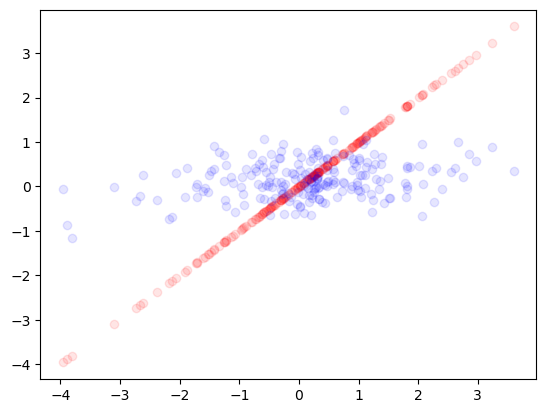

In [50]:
plt.scatter(x=y_test,y=y_test,c="r",alpha=0.1,label="true")
plt.scatter(x=y_test,y=pred_extreme,c="b",alpha=0.1,label="pred")
plt.show()

Test on test set without extreme value: 

In [51]:
mse_noextreme

1.3473170335866287

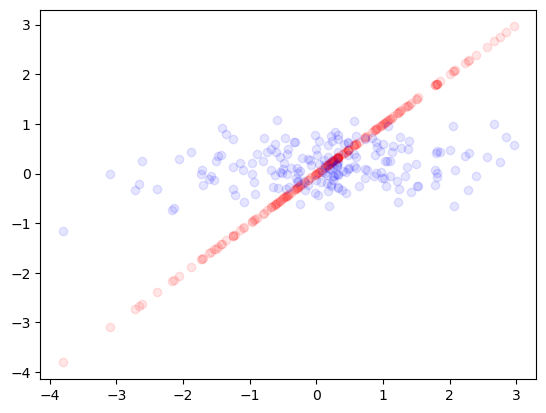

In [52]:
plt.scatter(x=y_de_test,y=y_de_test,c="r",alpha=0.1,label="true")
plt.scatter(x=y_de_test,y=pred_noextreme,c="b",alpha=0.1,label="pred")
plt.show()

Is not really better. 

Then train with extreme values.

In [53]:
spineline_pipe = Pipeline([
    ("std", StandardScaler()),                  # standardize features
    ("spline", SplineTransformer(n_knots=2, degree=1)),
    ("regressor", LinearRegression())           # final estimator
])
spineline_pipe.fit(X=X_train,y=y_train)
pred_extreme=spineline_pipe.predict(X=X_test)
mse_extreme=mean_squared_error(y_pred=pred_extreme,y_true=y_test)
pred_noextreme=spineline_pipe.predict(X=X_de_test)
mse_noextreme=mean_squared_error(y_pred=pred_noextreme,y_true=y_de_test)

Test without extreme value: 

In [54]:
mse_extreme

1.5124739248435195

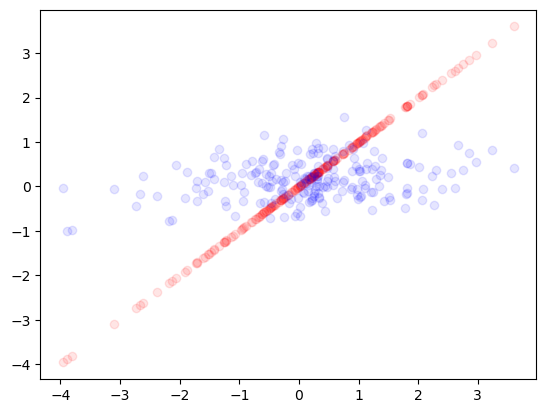

In [55]:
plt.scatter(x=y_test,y=y_test,c="r",alpha=0.1,label="true")
plt.scatter(x=y_test,y=pred_extreme,c="b",alpha=0.1,label="pred")
plt.show()

Test with extreme value: 

In [56]:
mse_noextreme

1.3591363272625205

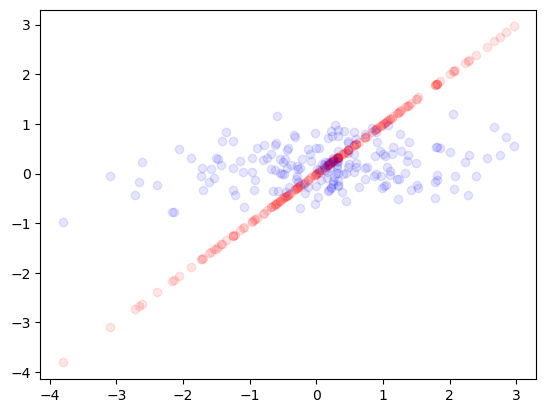

In [57]:
plt.scatter(x=y_de_test,y=y_de_test,c="r",alpha=0.1,label="true")
plt.scatter(x=y_de_test,y=pred_noextreme,c="b",alpha=0.1,label="pred")
plt.show()

Seems to have a "better slope". 